# LSI31003 Machine Learning in Molecular Biology Assignment 4

In [2]:
library(ggplot2)
library(rBeta2009)
library(grid)
library(repr)
library(reshape2)
library(NMF)
library (scales)
library(pastecs)
library(dendextend)
library(latticeExtra)
library(Rmisc)
library(ggpmisc)
library(gplots)
library(car)

# Problem 1: Mixture models

## Read in data

In this exercise we will use data of mutational positions along 23 chromosomes. The file `PD4107.mutations.txt` contains 10291 positions where there are mutations. There is also information about how many of the total reads had the mutated base, but this information is not needed for the exercises.

In [3]:
bc_mut<-read.table("PD4107.mutations.txt",sep="\t",header=T)
#bc_mut$chr_f<-paste("chr",bc_mut$chr,sep="")
bc_mut$chr<-factor(bc_mut$chr, levels=c(1:22,"X"))
#bc_mut$chr_f<-paste("chr",bc_mut$chr_f,sep="")
chrs<-unique(bc_mut$chr)
order<-NULL
for (i in 1:length(chrs)){
    mut_order<-1:sum(bc_mut$chr==chrs[i])
    order<-c(order,mut_order)
}
bc_mut$order<-order
head(bc_mut)
length(bc_mut$order)-23

chr,pos,tot_reads,mut_reads,order
1,1857336,15,4,1
1,2329409,52,15,2
1,2620133,14,2,3
1,3050359,19,1,4
1,3093904,44,16,5
1,3802432,34,8,6


[1] 10268

## Plot distances between mutations for each chromosome

The plot below shows cumulatively how the mutations are spread along the nucleotide positions for each chromosome.

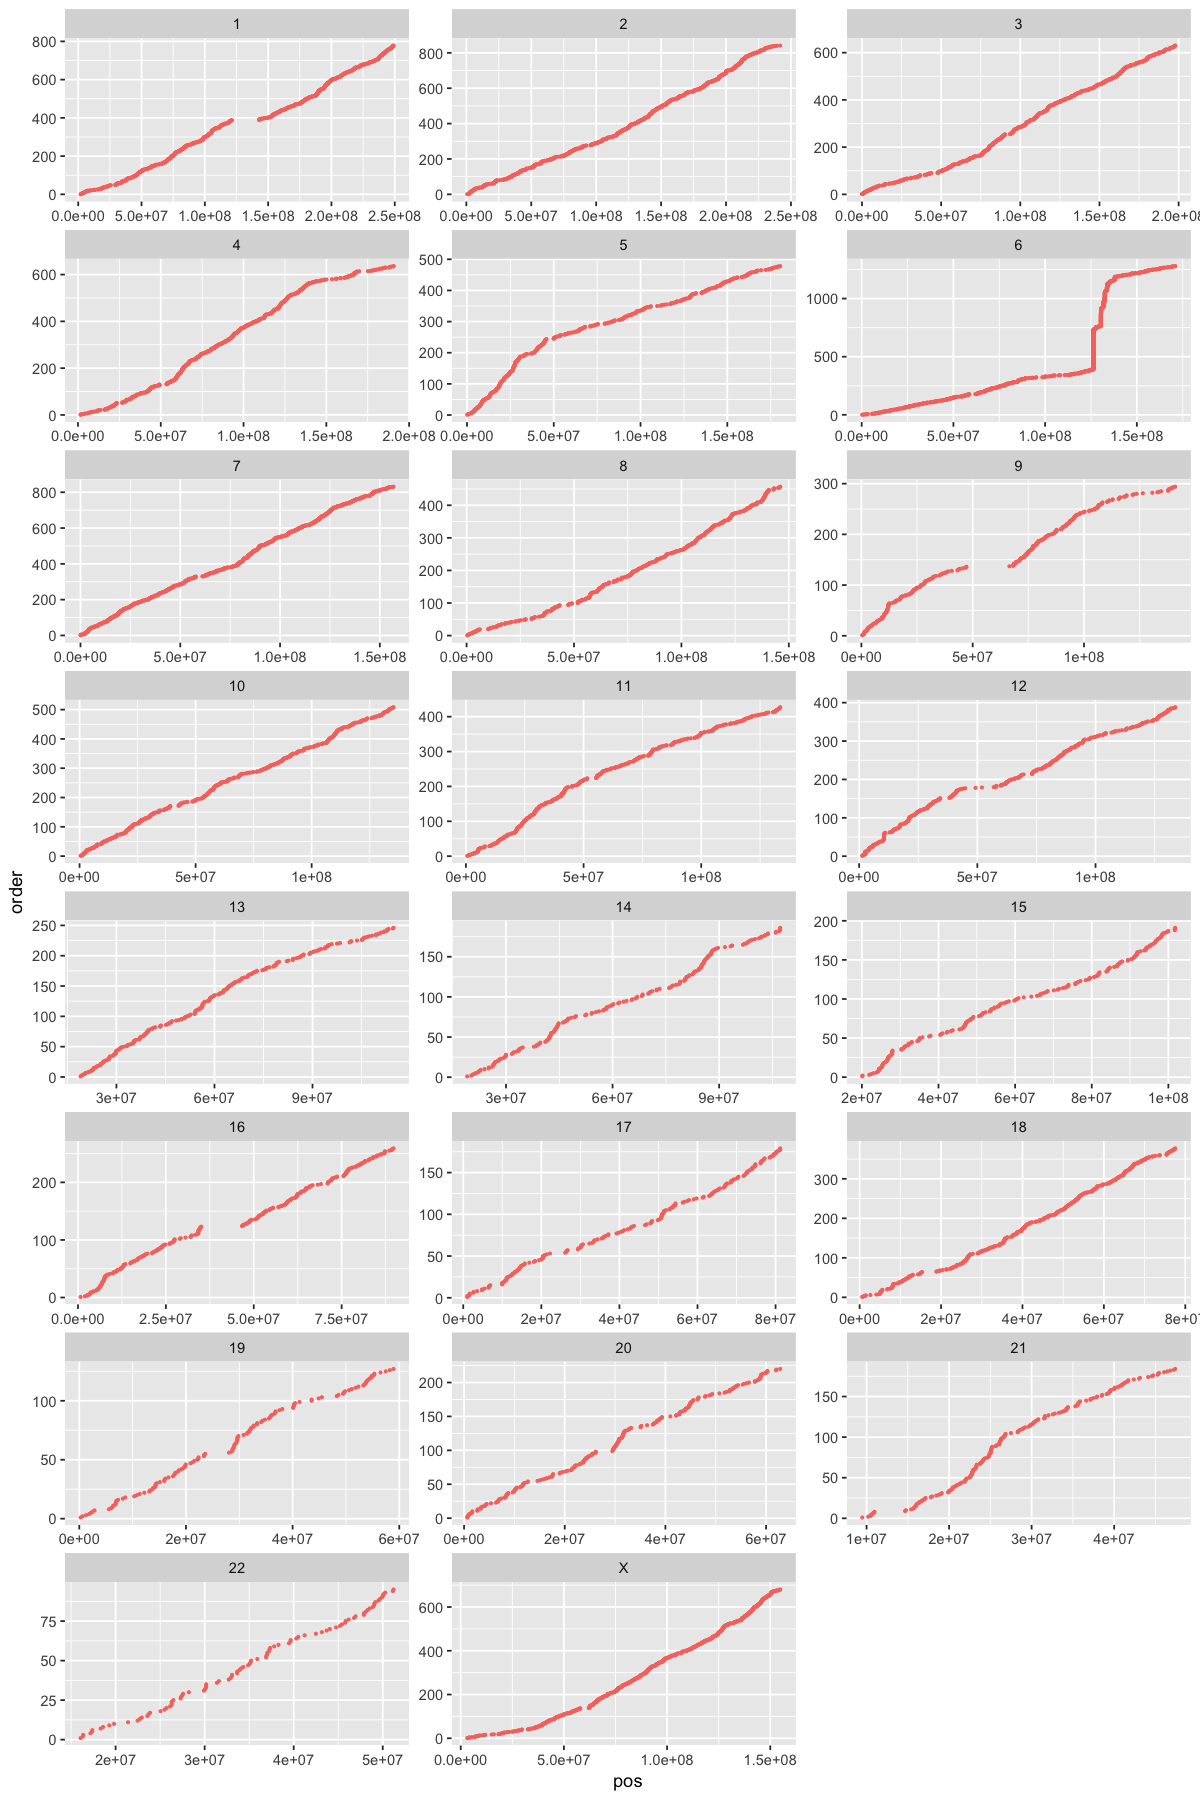

In [4]:
options(repr.plot.width=10, repr.plot.height=15)
plot<-ggplot(bc_mut, aes(x=pos, y=order)) + geom_point(aes(color="tomato"),size=0.5)
plot<-plot+facet_wrap( ~ chr,scale="free",ncol=3) + theme(legend.position="none")
plot

## Problem 1a: rainfall plots and histograms

The internucleotide distances between mutations can be neatly visualised using something called a rainfall plot (example: https://www.nature.com/articles/ncomms10001/figures/5). Make a rainfall plot from the above data, showing distances between subsequent mutations on the _y_-axis and simply the index of the mutation on the _x_-axis so that neighbouring mutations are next to each other on the plot. You should get 10268 distance values. The plot should tell you if there are regions with different mutational rates. Instead of plotting chromosomes separately, have all the points one the same figure and mark the splits between chromosomes. Use logarithmic scale on the _y_-axis.

Additionally, make a histogram of all distances between subsequent mutations (i.e. collapse the data points on the _y_-axis). Use logarithmic scale on the _x_-axis. Estimate visually the location of the peak in the distribution of internucleotide mutation distances.

In [5]:
dist_bc_mut<-NULL
for (i in 1:length(chrs)){
    dataset<-bc_mut[bc_mut$chr==chrs[i],]
    dataset<-dataset[order(dataset$pos),]
    num_mut<-length(dataset$chr)
    distance_log<-NULL
    distance<-NULL
    for (j in 1:(num_mut-1)){
        mut_dist<-dataset$pos[j+1]-dataset$pos[j]
        distance_log<-c(distance_log,log(mut_dist))
        distance<-c(distance,mut_dist)
        
    }
    dataset<-dataset[1:num_mut-1,]
    dataset$distance_log<-distance_log
    dataset$distance<-distance
    dist_bc_mut<-rbind(dist_bc_mut,dataset)
}
dim(dist_bc_mut)

[1] 10268     7

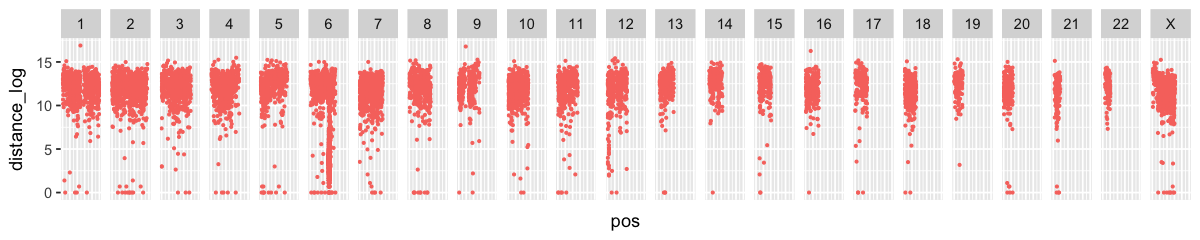

In [6]:
options(repr.plot.width=10, repr.plot.height=2)
plot<-ggplot(dist_bc_mut, aes(x=pos, y=distance_log)) + geom_point(aes(color="tomato"),size=0.5)
plot<-plot+facet_wrap( ~ chr,ncol=23) + theme(legend.position="none")
plot+theme(axis.text.x=element_blank(),axis.ticks.x=element_blank())

## Problem 1b: mixture model estimation

Assuming that the mutations arise independently, the distances between subsequent mutations could be assumed to be distributed according to a) the (shifted) geometric distribution or b) the exponential distribution. For this exercise you can choose which distribution you want to use.

Before going to the mixture of two distributions, first assume that the values come from a single distribution. Find the maximum likelihood estimate for the parameter of that distribution given the data. State also the log-likelihood value at this estimate.

Looking at the figures above you should notice that the distribution of distances is somewhat bimodal, such that the points come from a mixture of two distributions. Assume a mixture of two distributions with parameters $\lambda_1$ and $\lambda_2$ and a probability $\mu$ to choose from distribution 1 (prob. $1-\mu$ to choose from distribution 2). Find the parameters $\lambda_1$, $\lambda_2$ and $\mu$ that give the best fit to the data. Use any means you like (e.g. gradient ascent, grid search, brute force). Most importantly: limit your search space to reasonable values!

You might want to use the maximum likelihood functions given below.

When you have a reasonably good estimate, sample 10268 values from your mixture of two distributions and compare the histograms of the actual data to your sampled points.

Compare also the log-likelihood values for the single distribution case and the mixture of two distributions case.

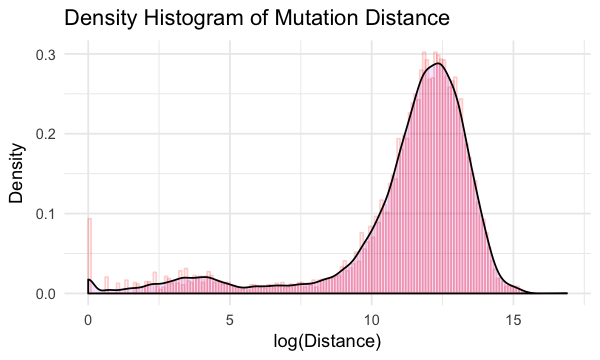

In [7]:
## Here I plot the histogram plot of all distance
dist_bc_mut_nonezero<-dist_bc_mut[dist_bc_mut$distance_log!=0,]
options(repr.plot.width=5, repr.plot.height=3)
carrotCol <- rgb(1,0,0,0.2)
plot<-ggplot(data=dist_bc_mut, aes(x=distance_log)) + geom_histogram(aes(y=..density..), breaks = seq(0, 16, 0.1),col=carrotCol, fill=carrotCol, alpha = .01) 
plot<-plot+labs(title="Density Histogram of Mutation Distance", x="log(Distance)", y="Density")+theme_minimal()+geom_density(alpha=.1, fill="purple")
plot

##### As we could see from the distance histogram plot, there are two distribution mixed. I will model them as two geometric distributions with two parameters $\lambda_1$, $\lambda_2$. And they have been mixed with $\mu$. That is:

#### g=$\mu$*f($\lambda_1$)+(1-$\mu$)*f($\lambda_2$);
#### f($\lambda_1$)=($\lambda_1$)*[(1-$\lambda_1$)^(D-1)];
#### f($\lambda_2$)=($\lambda_2$)*[(1-$\lambda_2$)^(D-1)].
#### D: distance

#### Based on my calculation, when the $\lambda$ takes the 1/Mean_of_given_data will maximize the likelihood function L($\lambda$). So I will give a guess of $\lambda_1$, $\lambda_2$ to be 1/3.75 and 1/12.5, and $\mu$ could be 0.1. The following code will take the three guesses as an inital value and it is going to find the values of them to make g fits with the data to the best level.

In [8]:
distance<-sort(dist_bc_mut$distance)
miu_s<-seq(0.001,1,by=0.001)
mle<-rep(NA,length(miu_s))
lamda1s<-rep(NA,length(miu_s))
lamda2s<-rep(NA,length(miu_s))
for (index in 1:length(miu_s)){
    miu<-miu_s[index]
    boundary<-as.integer(length(distance)*miu)
    boundary
    dist_f1<-distance[1:boundary]
    dist_f2<-distance[boundary:length(distance)]
    dim(as.matrix(dist_f1))
    lamda1<-1/mean(dist_f1)
    lamda2<-1/mean(dist_f2)
    ll<-sum(apply(as.matrix(dist_f1),2,function(d) log(lamda1*exp(-lamda1*d))))+sum(apply(as.matrix(dist_f2),2,function(d) log(lamda2*exp(-lamda2*d))))    
    mle[index]<-ll
    lamda1s[index]<-lamda1
    lamda2s[index]<-lamda2
#   print (c(miu,abs(ll),lamda1,lamda2))    
}
combinations<-data.frame(lamda1=lamda1s,lamda2=lamda2s,miu=miu_s,log_ll=mle)
log_ll_pool<-combinations$log_ll[combinations$log_ll!="Inf" & combinations$log_ll!="NA" & combinations$log_ll!="NaN"]
mll<-max(log_ll_pool)
solution<-combinations[combinations$log_ll==mll,]
solution

,lamda1,lamda2,miu,log_ll
82,0.009317217,3.221539e-06,0.082,-133424.6


#### The above step has found lamda1, lamda2 and miu which are the parameters made the model the fit perfectly with the gaiven data. Next, I will use this three parameters to simulate a dataset and compare the distributions of the given dataset and simulation dataset.

In [9]:

sample_size<-10268
lamda1<-solution$lamda1
lamda2<-solution$lamda2
miu<-solution$miu

set.seed(1)
sample_size_f1<-as.integer(miu*sample_size)

sample_f1<-as.matrix(trunc(rexp(n = sample_size_f1, rate = lamda1)))

set.seed(2)
sample_size_f2<-sample_size-sample_size_f1
sample_f2<-as.matrix(trunc(rexp(n = sample_size_f2, rate = lamda2)))

Warning message:
“Removed 11 rows containing non-finite values (stat_bin).”

Warning message:
“Removed 11 rows containing non-finite values (stat_density).”

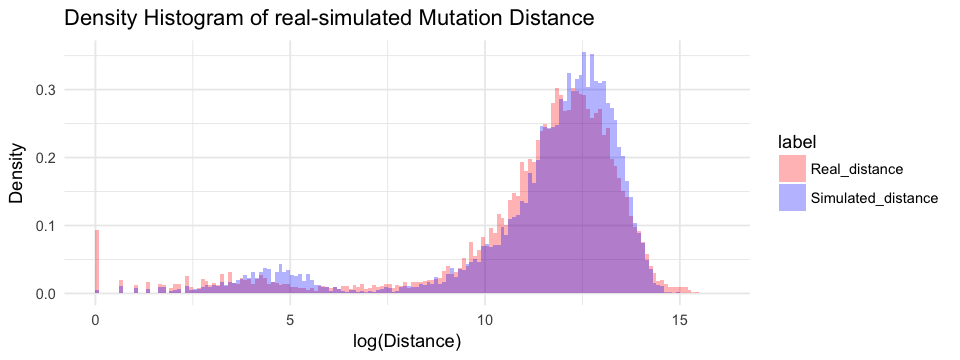

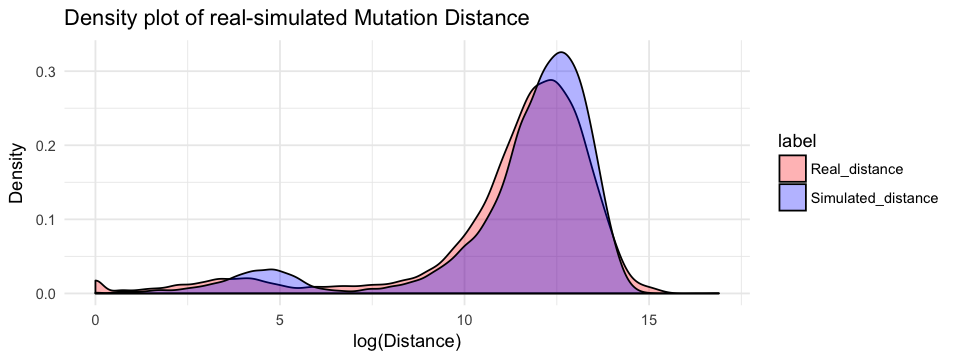

In [10]:
samples<-rbind(as.matrix(dist_bc_mut$distance),sample_f1,sample_f2)

label<-as.factor(c(rep("Real_distance",sample_size),rep("Simulated_distance",sample_size)))

plot_distance<-data.frame(distance_log=log(samples),label=label)

options(repr.plot.width=8, repr.plot.height=3)
carrotCol <- rgb(1,0,0,0.2)
cukeCol <- rgb(0,0,1,0.2)
#ggplot(vegLengths, aes(length, fill = veg)) + geom_histogram(alpha = 0.5, aes(y = ..density..), position = 'identity')

plot<-ggplot(data=plot_distance, aes(x=distance_log,fill=label)) + geom_histogram(aes(y=..density..),breaks = seq(0, 16, 0.1), alpha = .3,position="identity") 
plot<-plot+labs(title="Density Histogram of real-simulated Mutation Distance", x="log(Distance)", y="Density")+theme_minimal()+scale_fill_manual(values=c(carrotCol,cukeCol)) 
plot
plot<-ggplot(data=plot_distance, aes(x=distance_log,fill=label)) 
plot<-plot+labs(title="Density plot of real-simulated Mutation Distance", x="log(Distance)", y="Density")+theme_minimal()+geom_density(alpha=.3)+scale_fill_manual(values=c(carrotCol,cukeCol)) 
plot

#### As we could see from the figure, the two distributions are very similar, which proved the model with the estimated parameters is applicable for the given dataset.

# Problem 2: Linear modelling

NOTE: This exercise is still subject to changes and we will go through it in detail on the last lecture (Mixed effects modelling). It is, however, highly advisable to have a good look at it before the lecture.

In this exercise we will use a subset of the data for the first exercise.

In [11]:
cosmic30<-read.csv("/Users/qingli/Project/Machine_Learning/data/MutSigCancer/cosmic30.csv",header=F)
cosmic30<-cosmic30[2:31,]
## 96 channels order 
channels96<-read.csv("/Users/qingli/Project/Machine_Learning/data/MutSigCancer/channels96.csv")
head(cosmic30,1)
head(channels96,1)
somatic_mut<-read.csv("/Users/qingli/Project/Machine_Learning/data/MutSigCancer/somaticMutations.csv")
head(somatic_mut,1)
dim(somatic_mut)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96
2,0.01109833,0.009149341,0.00149007,0.006233885,0.00659587,0.007342368,0.0008928404,0.007186582,0.008232604,0.005758021,⋯,0.001599549,0.002758538,9.9045e-05,0.0002023656,0.001188353,0.0008007233,0.001397554,0.001291737,0.002031077,0.004030128


mutation.type,mutation.context,mutation
C>A,A_A,C>A@A_A


cancer_type,C.A.A_A,C.A.A_C,C.A.A_G,C.A.A_T,C.A.C_A,C.A.C_C,C.A.C_G,C.A.C_T,C.A.G_A,⋯,T.G.C_G,T.G.C_T,T.G.G_A,T.G.G_C,T.G.G_G,T.G.G_T,T.G.T_A,T.G.T_C,T.G.T_G,T.G.T_T
ALL,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 7016   97

## Problem 2A: colorectal cancer

Looking at a histogram of the total number of mutations in colorectal cancer samples there seem to be two groups: $< 5000$ mutations and $> 5000$ mutations. Find out which two signatures are most commonly found in the group with the high number of mutations.

When you have identified the most important two signatures, label the samples based on whether each of those signatures are present or not. You can use NMF to identify these and pick an arbitrary threshold value for classification. Then make a linear model with the presence of those signatures as the independent variables and the total number of mutations as the dependent variable, and see how well those two signatures explain the differences in observed mutational counts. In addition to the main effects, investigate also the interaction of the signatures. Since the dependent variable represents a count, use Poisson distributed errors.


In [12]:
unique(somatic_mut$cancer_type)
crc<-somatic_mut[somatic_mut$cancer_type=="Colorectum",]
head(crc,1)
dim(crc)

[1] ALL                  AML                  Bladder             
 [4] Breast               CLL                  Cervix              
 [7] Colorectum           Esophageal           Glioblastoma        
[10] GliomaLowGrade       HeadandNeck          KidneyChromophobe   
[13] KidneyClearCell      KidneyPapillary      Liver               
[16] LungAdeno            LungSmallCell        LungSquamous        
[19] LymphomaB-cell       Medulloblastoma      Melanoma            
[22] Myeloma              Neuroblastoma        Ovary               
[25] Pancreas             PilocyticAstrocytoma Prostate            
[28] Stomach              Thyroid              Uterus              
30 Levels: ALL AML Bladder Breast CLL Cervix Colorectum ... Uterus

,cancer_type,C.A.A_A,C.A.A_C,C.A.A_G,C.A.A_T,C.A.C_A,C.A.C_C,C.A.C_G,C.A.C_T,C.A.G_A,⋯,T.G.C_G,T.G.C_T,T.G.G_A,T.G.G_C,T.G.G_G,T.G.G_T,T.G.T_A,T.G.T_C,T.G.T_G,T.G.T_T
1560,Colorectum,1,4,0,3,6,15,7,48,2,⋯,9,7,1,2,1,0,0,0,1,1


[1] 559  97

In [13]:
total<-apply(crc[,2:97],1,function(x) sum(x))
length(total)

[1] 559

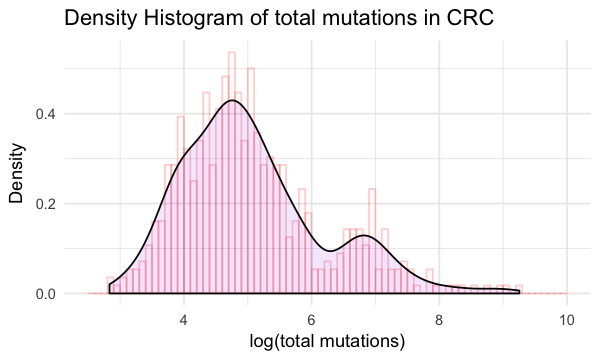

In [14]:
options(repr.plot.width=5, repr.plot.height=3)
carrotCol <- rgb(1,0,0,0.2)
plot<-ggplot(data=crc, aes(x=log(total))) + geom_histogram(aes(y=..density..),breaks = seq(2.5, 10, 0.1), col=carrotCol, fill=carrotCol, alpha = .01) 
plot<-plot+labs(title="Density Histogram of total mutations in CRC", x="log(total mutations)", y="Density")+theme_minimal()+geom_density(alpha=.1, fill="purple")
plot

In [15]:
## From the above distribution, we can see the mutation load is mixed from two models. we will set 6.3 as the cut off;
cutoff<-6.3
higher_mut_cutoff<-exp(cutoff)
higher_mut_cutoff
crc$total<-total
higher_mut<-crc[crc$total>higher_mut_cutoff,]

[1] 544.5719

#### Based on the cutoff, extract the mutational spectrum with higher mutation load.

In [16]:
crc_higher_mut_96channels<-t(higher_mut[,2:97])
head(crc_higher_mut_96channels)
dim(crc_higher_mut_96channels)

,1560,1561,1562,1563,1564,1567,1568,1572,1579,1581,⋯,2032,2057,2075,2081,2091,2103,2106,2112,2113,2116
C.A.A_A,1,2,3,0,2,0,2,0,1,1,⋯,1,3,1,2,1,1,1,0,1,2
C.A.A_C,4,4,3,6,1,3,2,1,4,4,⋯,1,2,1,2,2,0,1,2,3,3
C.A.A_G,0,2,0,1,0,0,0,1,0,0,⋯,0,0,1,1,0,0,0,2,1,1
C.A.A_T,3,15,1,2,1,0,2,1,1,4,⋯,5,2,1,3,1,1,0,2,6,5
C.A.C_A,6,8,13,3,3,6,6,6,5,21,⋯,5,30,14,15,2,5,7,8,20,18
C.A.C_C,15,0,22,12,15,18,14,17,14,23,⋯,14,23,10,28,9,11,4,15,34,29


[1] 96 88

#### The followings are few functions to calculate reconstruction errors from NMF given the composition dataset.

In [17]:
Euclidian_distance<-function(vectorA,vectorB){
    sum_A_B_2<-0

    value_numA<-length(vectorA[,1])
    value_numB<-length(vectorB[,1])
    if(value_numA==value_numB){
        for(i in 1:value_numA){
            sum_A_B_2<-sum_A_B_2+(vectorA[i,1]-vectorB[i,1])**2
        }
    }
    sqrt(sum_A_B_2)
}

reconst_error<-function(samples,activity_num,repeat_nmf,seed){
    size<-dim(samples)[2]
    errors<-matrix(replicate(repeat_nmf,0),ncol=1)
    
    ## here we repeat the NMF deconvolution for 100 times. it is good to know the variance between the results
    
    for (i in 1:repeat_nmf){
        set.seed(repeat_nmf)
        NMF_sig<-nmf(samples,activity_num)
        signatures_W <- NMF_sig@fit@W
       
        contribution_H <- NMF_sig@fit@H
        reconstruct_M<-signatures_W %*% contribution_H
        
        reconstruct_error<-0
        
        for (j in 1:size){
            orignal_sample<-as.matrix(samples[,j])
            reconstruct_sample<-as.matrix(reconstruct_M[,j])
    
            error<-Euclidian_distance(orignal_sample,reconstruct_sample)
            reconstruct_error<-reconstruct_error+error
        }
        errors[i,1]<-reconstruct_error    
    }
    errors
}

#### Code to call the reconstruction errors for the higher mutation load samples:

In [19]:
errors<-matrix(replicate(50*8,0),ncol=8) ## size==100, 8==length(2:9) 
j<-0
for (i in 2:9){
    activity_num<-i
    j<-j+1
    errors[,j]<-reconst_error(crc_higher_mut_96channels,activity_num,50,i)
}

#### Plot the median construciton errors for different models generated from the above codes; From which, I use red dash line to highlight the final solution for the model selection. N=6

integer(0)

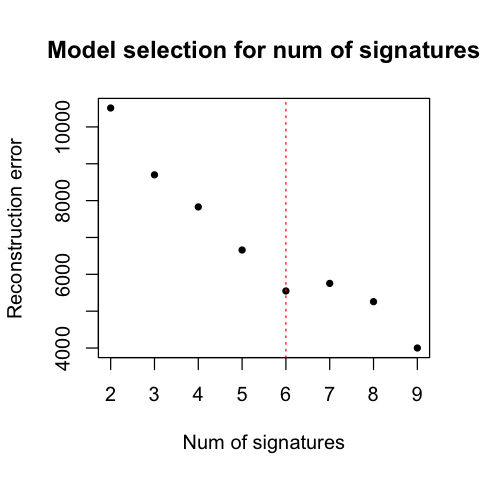

In [20]:
lables<-paste("Model_N",2:9,sep="")
median_cons_errors<-apply(errors,2,median)
#median_errors<-data.frame(N_sig=labels,error<-median_cons_errors)
options(repr.plot.width=4, repr.plot.height=4)
plot(2:9,median_cons_errors,main="Model selection for num of signatures", 
  	xlab="Num of signatures", ylab="Reconstruction error", pch=20)+abline(v=6,lty=3,col="red")

#### If N=6, the following code is going to use NMF to call signatures and their contribution matrix:

In [21]:
set.seed(1234)
NMF_sig<-nmf(crc_higher_mut_96channels,6)
signatures_W <- NMF_sig@fit@W       
contribution_H <- NMF_sig@fit@H

#### The functions below will compare the inferred signatures from NMF to the known Cosmic signatures based on their cosine similarities;

In [22]:
## Calculate cosine similarity between two vectors.
cosine_similarity<-function(vectorA,vectorB){
    sum_AxB<-0
    sum_A2<-0
    sum_B2<-0
    
    value_numA<-length(vectorA[,1])
    value_numB<-length(vectorB[,1])
    if(value_numA==value_numB){
        for(i in 1:value_numA){
            sum_AxB<-sum_AxB+vectorA[i,1]*vectorB[i,1]
            sum_A2<-sum_A2+vectorA[i,1]*vectorA[i,1]
            sum_B2<-sum_B2+vectorB[i,1]*vectorB[i,1]
        }
    }
    sum_AxB/(sqrt(sum_A2)*sqrt(sum_B2))
}

cosine_dist_matrix<-function(sig){
    length_sig<-dim(sig)[2]
    distance<-matrix(replicate(length_sig*length_sig,0),ncol=length_sig)

    for(i in 1: (dim(sig)[2])){    
        sig1<-as.matrix(sig[,i])
        for (j in 1:dim(sig)[2]){
            sig2<-as.matrix(sig[,j])        
            distance[i,j]<-1-cosine_similarity(sig1,sig2)
        }
    }
    as.dist(distance)   
}

simlarity_sig<-function(dataset,width,height,margin1,margin2,flag="N"){
    data<-as.matrix(dataset)
    number_sig<-dim(data)[2]
    dis_matrix<-matrix(replicate(number_sig*number_sig,0),ncol=number_sig)
    colnames(dis_matrix)<-colnames(dataset)
    rownames(dis_matrix)<-colnames(dataset)
    ## calculate the cosine matrix
    for (i in 1:number_sig){
        pred_sig<-as.matrix(data[,i])
        for (j in 1:number_sig){
            picked_sig<-as.matrix(data[,j])           
            dis_matrix[i,j]<-cosine_similarity(pred_sig,picked_sig)
            if (i<j && dis_matrix[i,j]>0.9 && sum(grep("isig",rownames(dis_matrix)[i]))==1){
                print (c(rownames(dis_matrix)[i],colnames(dis_matrix)[j],dis_matrix[i,j]))
            }
        }
    }
    colnames(dis_matrix)<-colnames(dataset)
    rownames(dis_matrix)<-colnames(dataset)

    dis_matrix_copy<-as.matrix(dis_matrix)
#    print(dis_matrix_copy)
    dis_matrix<- as.dist(as.matrix(dis_matrix))
    options(repr.plot.width=width, repr.plot.height=height)
    mycol <- colorpanel(40, "royalblue4","mistyrose","red4")
#    print (dis_matrix)
    if (flag=="Y"){
        heatmap.2(dis_matrix_copy, col=mycol,scale="none", density.info="none",key.xlab="Cosine Similarity", 
              trace="none",margins = c(margin1,margin2),key.title="",keysize = 1.2)
   } 
}

#### Calling the funtions in the above cell to compare the inferred signatures to cosmic signatures 

[1] "Signature contribution rank:"


[1] 202055.9 200016.4 176159.9 152403.1 124315.5 114877.7

[1] "The relationship between the identified signatures (isig) and Cosmic signatures (sig1-30):"
[1] "isig_1"            "sig_10"            "0.995619831950477"
[1] "isig_3"            "sig_1"             "0.915944623354055"
[1] "isig_3"            "sig_6"             "0.925589460716174"
[1] "isig_6"            "sig_15"            "0.933558953227041"


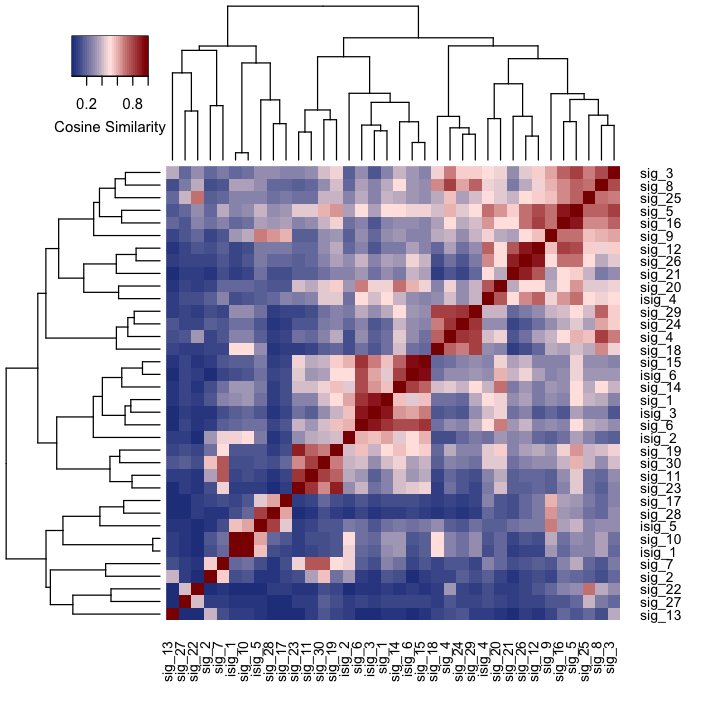

In [23]:
print("Signature contribution rank:")
sort(apply(signatures_W,2,sum),T)
colnames(signatures_W)<-paste("isig",1:6,sep="_")
known_cosmicSig<-cosmic30
known_cosmicSig_bycol<-t(known_cosmicSig)
colnames(known_cosmicSig_bycol)<-paste("sig",1:30,sep="_")
rownames(known_cosmicSig_bycol)<-NULL
#head(known_cosmicSig_bycol,2)
#simlarity_sig(known_cosmic6Sig_bycol,5,5,5,5)
mix<-cbind(signatures_W,known_cosmicSig_bycol)
print ("The relationship between the identified signatures (isig) and Cosmic signatures (sig1-30):")
simlarity_sig(mix,6,6,5,5,"Y")

#### From the above analysis, the isig_1 is almost equal to sig 10 ; isig_3 is similar to sig_6 and sig_1; and isig_6 is similar to sig_15. From the contribution rank, the top2 mutation count constributors would be isig_1(sig10) and isig_3 (sig6).

#### Calculate the contributed mutations by sig 10 and sig6 for the samples with higher mutations. Next, I will generate the bar plot for the total mutation count for those samples (samples ranked by the sig10 contributions in each sample) and the scatter plot for signature 10 and signature 6's contribution in each sample:

,sample,count,isig1_or_sig10,isig3_or_sig6,prop_sig10,prop_sig6
10,s1581,1921,4.486542e-11,454.9348,2.335524e-14,0.2368219
73,s1983,1230,4.486542e-11,192.0407,3.647595e-14,0.1561307
56,s1833,1075,4.486542e-11,142.5933,4.173527e-14,0.1326449
53,s1824,1063,4.486542e-11,470.5148,4.220641e-14,0.4426291
59,s1911,864,4.486542e-11,810.6234,5.192757e-14,0.9382215
24,s1662,808,4.486542e-11,263.3851,5.552651e-14,0.3259716


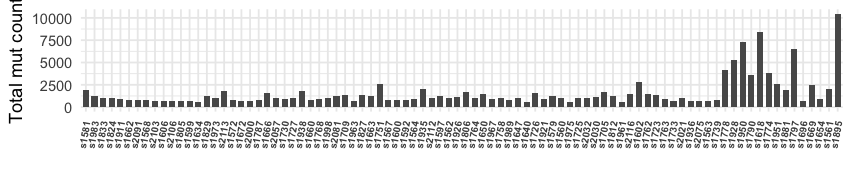

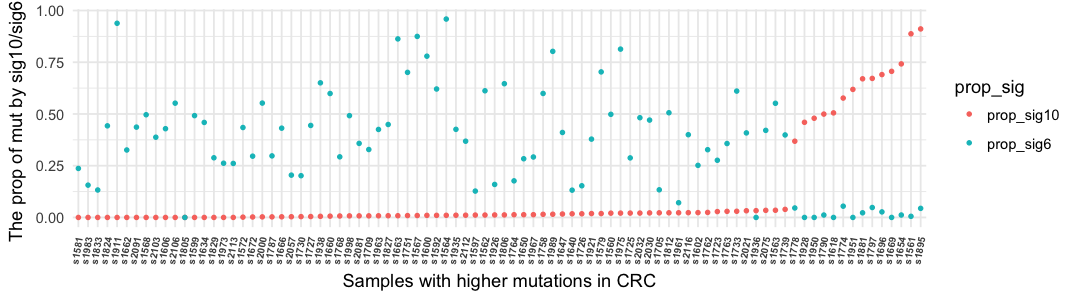

In [24]:
sample_size<-88
higher_mut_from_isig1<-NULL
higher_mut_from_isig3<-NULL
linear_model_data<-NULL
for(i in 1:sample_size){
    higher_mut_from_isig1<-c(higher_mut_from_isig1,sum(contribution_H[1,i]*signatures_W[,1]))
    higher_mut_from_isig3<-c(higher_mut_from_isig3,sum(contribution_H[3,i]*signatures_W[,3]))   
}
linear_model_data<-data.frame(sample=paste("s",row.names(higher_mut),sep=""),count=higher_mut$total,isig1_or_sig10=higher_mut_from_isig1,isig3_or_sig6=higher_mut_from_isig3)
linear_model_data$prop_sig10<-linear_model_data$isig1_or_sig10/linear_model_data$count
linear_model_data$prop_sig6<-linear_model_data$isig3_or_sig6/linear_model_data$count

order_linear_model_data<-linear_model_data[order(linear_model_data$prop_sig10),]
head(order_linear_model_data)
for_plot<-melt(order_linear_model_data,id.vars = "sample", measure.vars = c("prop_sig10","prop_sig6"))
#head(for_plot)
colnames(for_plot)<-c("sample","prop_sig","proportion")
for_plot$sample<-factor(for_plot$sample,levels=as.vector(order_linear_model_data$sample))
order_linear_model_data$sample<-factor(order_linear_model_data$sample,levels=as.vector(order_linear_model_data$sample))
options(repr.plot.width=7.1, repr.plot.height=1.5)
plot<-ggplot(order_linear_model_data,aes(x=sample,y=count))+geom_bar(stat="identity",width=0.7)
plot+theme_minimal()+theme(axis.text.x = element_text(angle = 80,face ="bold",size = 6, vjust = 0,hjust = 0))+xlab("")+ylab("Total mut count")
options(repr.plot.width=9, repr.plot.height=2.5)
plot<-ggplot(for_plot, aes(x=sample, y=proportion, col=prop_sig)) + geom_point(pch=20)
plot<-plot+theme_minimal()+theme(axis.text.x = element_text(angle = 80,face ="bold",size = 6, vjust = 0,hjust = 0))
plot+xlab("Samples with higher mutations in CRC")+ylab("The prop of mut by sig10/sig6 ")


#### From the above two figures, we could find out that samples with higher percent of mutation contributed by sig6 have nearly zero mutation from sig10, and vice verse. I will use 5 percent as a threshold to determine if sig 6/sig10 has contributed to each sample or not. 

In [25]:
linear_model_data$contributed_bySig10 <- as.numeric(linear_model_data$prop_sig10>0.05)
linear_model_data$contributed_bySig6<- as.numeric(linear_model_data$prop_sig6>0.05)
linear_model_data$contributed_byOthersOnly<-as.numeric(-linear_model_data$prop_sig10>0.05 && 
                                                       linear_model_data$prop_sig6>0.05)
head(linear_model_data)

sample,count,isig1_or_sig10,isig3_or_sig6,prop_sig10,prop_sig6,contributed_bySig10,contributed_bySig6,contributed_byOthersOnly
s1560,1069,22.170412,532.65618,0.020739394,0.498275191,0,1,0
s1561,1975,1752.610064,10.68685,0.887397501,0.005411062,1,0,0
s1562,1075,12.531687,657.97389,0.011657383,0.612068730,0,1,0
s1563,656,22.814383,361.90082,0.034778023,0.551678080,0,1,0
s1564,946,9.793966,906.90157,0.010353030,0.958669735,0,1,0
s1567,812,7.521806,710.34552,0.009263308,0.874809749,0,1,0


In [26]:
sig10_index<-linear_model_data$contributed_bySig10==1
mean(linear_model_data$count[sig10_index])
var(linear_model_data$count[sig10_index])

[1] 4296.929

[1] 8630046

In [27]:
sig6_index<-linear_model_data$contributed_bySig6==1
mean(linear_model_data$count[sig6_index])
var(linear_model_data$count[sig6_index])

[1] 1128.986

[1] 286624.8

In [28]:
mean(linear_model_data$count[linear_model_data$contributed_byOthersOnly==1])
var(linear_model_data$count[linear_model_data$contributed_byOthersOnly==1])

[1] NaN

[1] NA

In [29]:
main_gmod <- lm(count ~ isig1_or_sig10 + isig3_or_sig6, data = linear_model_data)
summary(main_gmod)


Call:
lm(formula = count ~ isig1_or_sig10 + isig3_or_sig6, data = linear_model_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2227.3  -322.4  -110.6   213.0  2383.9 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    850.58736  115.58070   7.359 1.08e-10 ***
isig1_or_sig10   1.21584    0.05128  23.710  < 2e-16 ***
isig3_or_sig6    0.54799    0.22431   2.443   0.0166 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 614.5 on 85 degrees of freedom
Multiple R-squared:  0.8704,	Adjusted R-squared:  0.8674 
F-statistic: 285.5 on 2 and 85 DF,  p-value: < 2.2e-16


In [30]:
AIC(main_gmod)

[1] 1384.729

#### The residues from the above linear model:

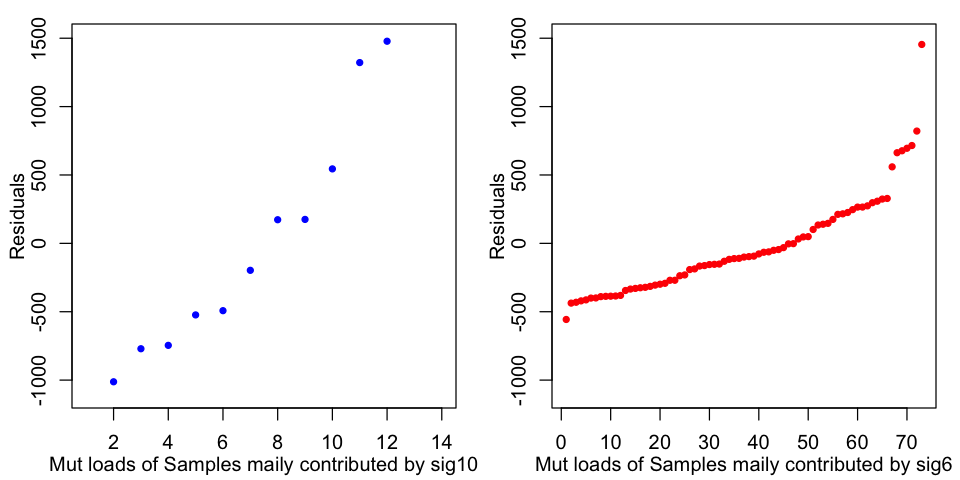

In [31]:
options(repr.plot.width=8, repr.plot.height=4)

par(mfrow=c(1,2),mar=c(3,3,1,1),mgp=c(1.8,0.9,0))

plot(sort(main_gmod$residuals[sig10_index]),pch=20,col="blue",ylim=c(-1100,1500),
     xlab="Mut loads of Samples maily contributed by sig10", ylab="Residuals")

plot(sort(main_gmod$residuals[sig6_index]),pch=20,col="red", ylim=c(-1100,1500),
     xlab="Mut loads of Samples maily contributed by sig6",ylab="Residuals")

#### the interaction of the signatures:

In [32]:
intr_gmod <- lm(count ~ isig1_or_sig10 + isig3_or_sig6 + isig1_or_sig10:isig3_or_sig6, data = linear_model_data)
summary(intr_gmod)


Call:
lm(formula = count ~ isig1_or_sig10 + isig3_or_sig6 + isig1_or_sig10:isig3_or_sig6, 
    data = linear_model_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1576.94  -210.59   -19.88   235.18  1424.31 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   5.526e+02  9.473e+01   5.833 9.86e-08 ***
isig1_or_sig10                1.722e+00  7.363e-02  23.381  < 2e-16 ***
isig3_or_sig6                 1.074e+00  1.814e-01   5.919 6.83e-08 ***
isig1_or_sig10:isig3_or_sig6 -1.564e-03  1.937e-04  -8.074 4.32e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 463.8 on 84 degrees of freedom
Multiple R-squared:  0.927,	Adjusted R-squared:  0.9244 
F-statistic: 355.8 on 3 and 84 DF,  p-value: < 2.2e-16


In [33]:
AIC(intr_gmod)

[1] 1336.186

In [34]:
Anova(intr_gmod,type='III')

,Sum Sq,Df,F value,Pr(>F)
(Intercept),7319289,1,34.02480,9.857204e-08
isig1_or_sig10,117593805,1,546.65219,1.575174e-38
isig3_or_sig6,7536603,1,35.03501,6.825082e-08
isig1_or_sig10:isig3_or_sig6,14021899,1,65.18287,4.320645e-12
Residuals,18069770,84,NA,NA


#### Poisson GLM

In [35]:
main_pmod <- glm(count ~ isig1_or_sig10 + isig3_or_sig6, data = linear_model_data, family=poisson())
intr_pmod<- glm(count ~ isig1_or_sig10 + isig3_or_sig6 + isig1_or_sig10:isig3_or_sig6, data = linear_model_data,
                family=poisson())

summary(intr_pmod)


Call:
glm(formula = count ~ isig1_or_sig10 + isig3_or_sig6 + isig1_or_sig10:isig3_or_sig6, 
    family = poisson(), data = linear_model_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-26.429  -10.099   -3.139    4.680   43.696  

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   6.762e+00  5.593e-03 1209.05   <2e-16 ***
isig1_or_sig10                6.014e-04  2.384e-06  252.33   <2e-16 ***
isig3_or_sig6                 5.585e-04  9.654e-06   57.85   <2e-16 ***
isig1_or_sig10:isig3_or_sig6 -7.812e-07  5.388e-09 -144.98   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 94637  on 87  degrees of freedom
Residual deviance: 13023  on 84  degrees of freedom
AIC: 13818

Number of Fisher Scoring iterations: 4


In [36]:
cat(exp(intr_pmod$coef[1]),'\n')
cat(exp(intr_pmod$coef[1] + intr_pmod$coef[2]),'\n')
cat(exp(intr_pmod$coef[1] + intr_pmod$coef[3]),'\n')

864.2215 
864.7414 
864.7043 


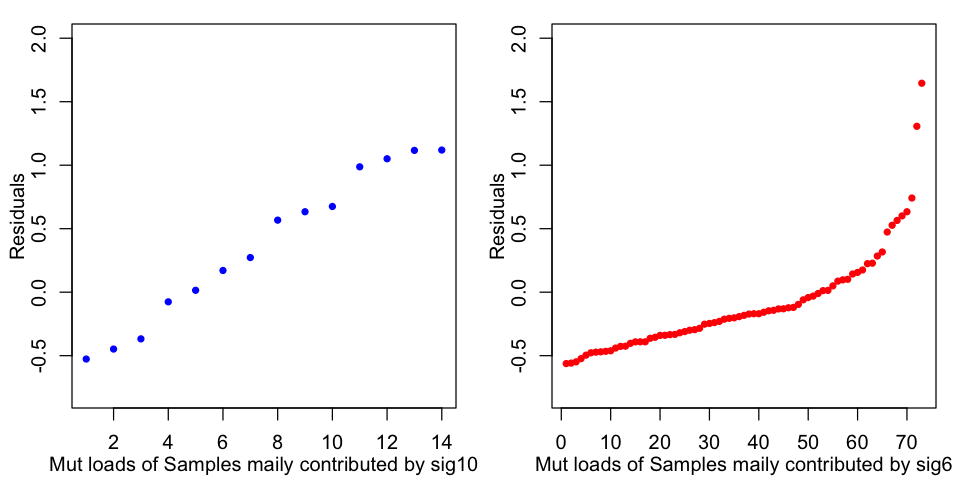

In [37]:
options(repr.plot.width=8, repr.plot.height=4)

par(mfrow=c(1,2),mar=c(3,3,1,1),mgp=c(1.8,0.9,0))

plot(sort(main_pmod$residuals[sig10_index]),pch=20,col="blue",ylim=c(-0.8,2),
     xlab="Mut loads of Samples maily contributed by sig10", ylab="Residuals")

plot(sort(main_pmod$residuals[sig6_index]),pch=20,col="red", ylim=c(-0.8,2),
     xlab="Mut loads of Samples maily contributed by sig6",ylab="Residuals")

In [38]:
drop1(main_pmod)

,Df,Deviance,AIC
<none>,NA,31406.42,32199.69
isig1_or_sig10,1,92401.60,93192.87
isig3_or_sig6,1,31725.51,32516.79
